In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['axes.edgecolor'] = 'k'

In [16]:
stock = 'NVDA'
start_date = '2022-01-01'
end_date = '2023-06-01'

data = yf.download(stock, start_date, end_date).drop('Close', axis=1)
factor_vars = ['Open', 'High', 'Volume']
target_var = 'Adj Close'

factors = data[factor_vars][1:]
prices = data[target_var]
prices.name = stock
target = np.log(prices).diff()[1:]

[*********************100%***********************]  1 of 1 completed


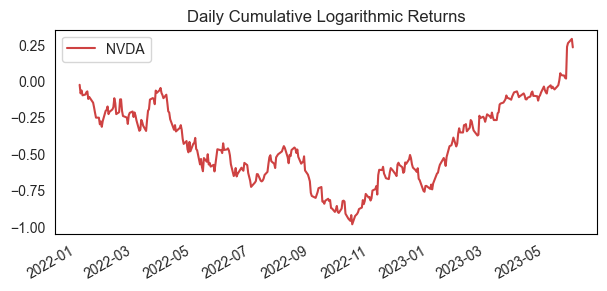

In [17]:
target.cumsum().plot(figsize=(7, 3), grid=False, color='#CE4242')
plt.title(f"Daily Cumulative Logarithmic Returns")
plt.xlabel('')
plt.legend();

In [18]:
factors.head(3)

,Open,High,Volume
Date,,,
2022-01-04,302.769989,304.679993,52715400
2022-01-05,289.489990,294.160004,49806400
2022-01-06,276.399994,284.380005,45418600


In [19]:
target.head(3)

Date
2022-01-04   -0.027976
2022-01-05   -0.059286
2022-01-06    0.020581
Name: NVDA, dtype: float64

In [20]:
window = 20
factors[f'{window}D_MA'] = prices[1:].rolling(window).mean()
factors[f'{window}D_Volatility'] = target.rolling(window).std() * np.sqrt(252)
factors = factors[window:]
target = target[window:]
factors.head(3)

,Open,High,Volume,20D_MA,20D_Volatility
Date,,,,,
2022-02-02,257.940002,258.170013,54341900,252.631654,0.554646
2022-02-03,244.580002,250.770004,41017800,250.805860,0.546837
2022-02-04,239.720001,246.350006,35482900,248.878689,0.543643


In [21]:
cpi = pd.read_csv('data/cpi.csv', index_col='DATE', parse_dates=True)
daily_inflation = cpi.pct_change(12).resample('D').interpolate('akima')
daily_inflation = daily_inflation.reindex(factors.index)
daily_inflation.head(3)

,USACPIALLMINMEI
Date,
2022-02-02,0.078854
2022-02-03,0.079020
2022-02-04,0.079206


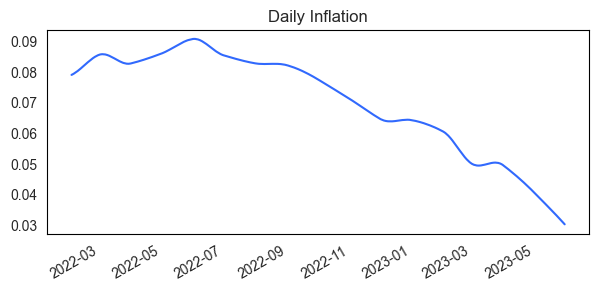

In [22]:
daily_inflation.plot(figsize=(7, 3), legend=False, grid=False, color='#3169FD')
plt.xlabel('')
plt.title('Daily Inflation');

In [23]:
factors['Inflation'] = daily_inflation
factors.head(3)

,Open,High,Volume,20D_MA,20D_Volatility,Inflation
Date,,,,,,
2022-02-02,257.940002,258.170013,54341900,252.631654,0.554646,0.078854
2022-02-03,244.580002,250.770004,41017800,250.805860,0.546837,0.079020
2022-02-04,239.720001,246.350006,35482900,248.878689,0.543643,0.079206


In [24]:
factors.isnull().sum()

Open              0
High              0
Volume            0
20D_MA            0
20D_Volatility    0
Inflation         0
dtype: int64

In [25]:
target.isnull().sum()

0

In [26]:
from sklearn.model_selection import train_test_split

seed = 88
test_size = 0.3

X = factors
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=seed, test_size=test_size)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((233, 6), (100, 6), (233,), (100,))

In [27]:
from rolling_scaler import RollingWindowScaler

